# Error analysis in multiclass classification

We can run a grid search to tune hyperparameters in a multiclass classification: 

In [1]:
# code from previous notebook of this section
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import numpy as np
from sklearn.svm import SVC

data = pd.read_csv('cl2_data.csv')

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

y_train = train_set['label']
X_train = train_set.drop(['label'], axis=1)

num_pipeline = make_pipeline(StandardScaler()) 

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number))])

model_svc = make_pipeline(preprocessing, SVC(kernel='rbf', C=1.0, random_state=42))
# end of code from previous notebook of this section

from sklearn.model_selection import GridSearchCV

param_grid = [{'svc__C': [0.1,0.5,1,5,10,50,100,500,1000],
              }]

grid_search = GridSearchCV(model_svc, param_grid, cv=5, scoring="f1_weighted")
grid_search.fit(X_train, y_train)

cv_hyperpara = pd.DataFrame(grid_search.cv_results_)
cv_hyperpara.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_hyperpara.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.029948,0.001811,0.009540,0.000129,500.0,{'svc__C': 500},0.930226,0.944843,0.942431,0.947741,0.934796,0.940007,0.006510,1
8,0.051154,0.013746,0.013101,0.004296,1000.0,{'svc__C': 1000},0.930226,0.947387,0.939946,0.945193,0.934796,0.939510,0.006371,2
6,0.021430,0.000632,0.009857,0.000110,100.0,{'svc__C': 100},0.932677,0.942372,0.942431,0.945134,0.929804,0.938484,0.006066,3
4,0.016629,0.000684,0.010636,0.000258,10.0,{'svc__C': 10},0.932811,0.942438,0.935092,0.950091,0.924615,0.937009,0.008666,4
1,0.020197,0.000130,0.015032,0.000160,0.5,{'svc__C': 0.5},0.930362,0.947614,0.940436,0.947624,0.917567,0.936720,0.011477,5


Our best model has a $F_1$ score of 0.94. The confusion matrix would be a good choice for a more detailed error analysis where a graphical support is desirable. This can be done by "ConfusionMatrixDisplay" with scikit-learn:

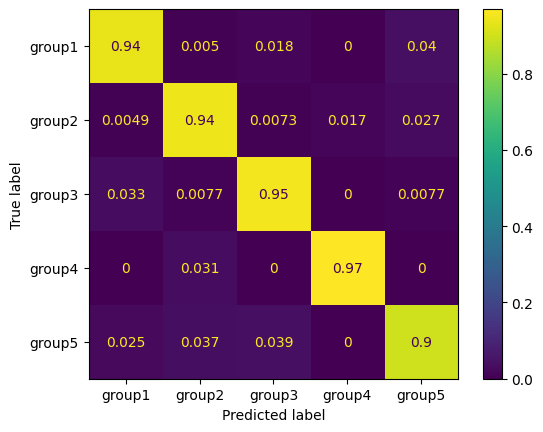

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

model_svc = make_pipeline(preprocessing, SVC(kernel='rbf', C=500.0, random_state=42))

y_train_pred = cross_val_predict(model_svc, X_train, y_train, cv=5)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true")

We see that the prediction of "group5" is most prone to false predictions. However, there is no problem to distinguish "group4" and "group5" from each other. If you plot larger confusion matrices, it might be desirable to highlight better areas with large errors. This can be done as follow: 

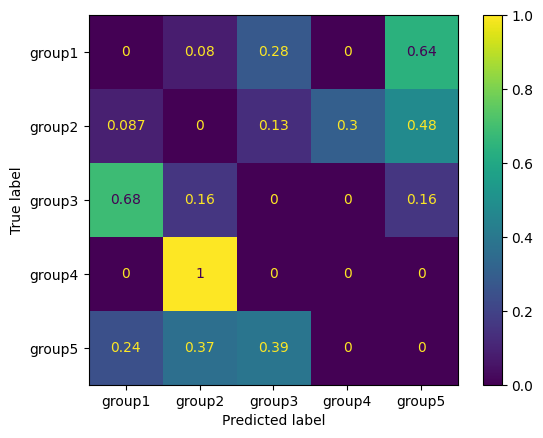

In [3]:
sample_weight_svc = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight_svc, normalize="true")

We see that "group4" instances are always predicted as "group2" if an error occurs. We see also that "group3" is most often false predicted as "group1". As you see, the matrix is normalized to the rows labels (true labels). We can also normalize it to the columns (predictions): 

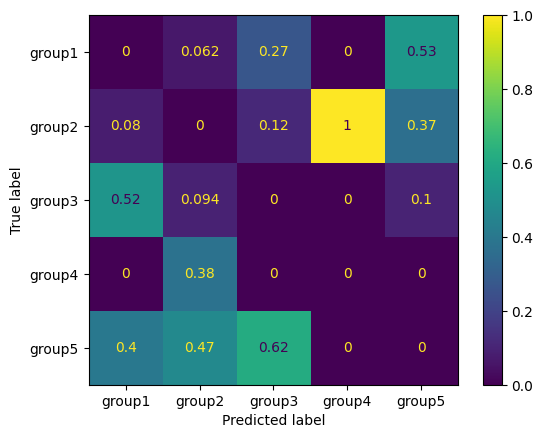

In [4]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight_svc, normalize="pred")